
# Pneumonia x Normal Chest X-Ray Image Classification

This project was designed to be an image classifier categorizing chest X-Ray images as Pneumonia and Normal. For this was used a dataset found in Kaggle, using this [link here](https://data.mendeley.com/datasets/rscbjbr9sj/2). This project will be using Google Colab, and below we'll be mounting Google Drive on It.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing packages

Let's start by importing required packages:

* os — to read files and directory structure
* numpy — for some matrix math outside of TensorFlow
* matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by unzipping the dataset.

In [ ]:
root_path = '/content/drive/MyDrive/DataSets'
os.chdir(root_path)

In [ ]:
!unzip ChestXRay2017.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray

We can list the directories with the following terminal command:

In [ ]:
dir = '/content/drive/MyDrive/DataSets/chest_xray'
zip_dir_base = os.path.dirname(dir)
!find $zip_dir_base -type d -print

/content/drive/MyDrive/DataSets
/content/drive/MyDrive/DataSets/chest_xray
/content/drive/MyDrive/DataSets/chest_xray/test
/content/drive/MyDrive/DataSets/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/DataSets/chest_xray/test/NORMAL
/content/drive/MyDrive/DataSets/chest_xray/train
/content/drive/MyDrive/DataSets/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/DataSets/chest_xray/train/NORMAL
/content/drive/MyDrive/DataSets/__MACOSX
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/test
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train/NORMAL


It's possible to see that we haven't a validation folder. Validate our training it's indispensable to prevent overfitting. So let's create it!

In [ ]:
path = os.path.join(dir, 'val')
os.mkdir(path)

In [ ]:
path_normal = os.path.join(dir, 'val/NORMAL')
os.mkdir(path_normal)

In [ ]:
path_pneumonia = os.path.join(dir, 'val/PNEUMONIA')
os.mkdir(path_pneumonia)

We'll now assign variables with the proper file path for the training and test sets.

In [ ]:
base_dir = os.path.join(os.path.dirname(dir), 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

### Data Understanding

Let's look at how many normal and pneumonia images we have in our training and test directory, to understand how many pictures will be necessary to transfer to validation folder.

In [ ]:
def get_total_chest_xray(category, source):
  """
  INPUT
  category: data set category, which could be 'training', 'test' and 'validation'
  source: a directory path.

  OUTPUT
  num_normal: total number of pictures
  num_pneumonia: 
  total: 

  DESCRIPTION
  This function move X (amount) random pictures from a source folder
  to destination folder.
  """
  source_normal = os.path.join(source, 'NORMAL') 
  source_pneumonia = os.path.join(source, 'PNEUMONIA')

  num_normal = len(os.listdir(source_normal))
  num_pneumonia = len(os.listdir(source_pneumonia))
  total = num_normal + num_pneumonia

  print('Total {}: {}'.format(category, total))
  print('total {} normal images: {}'.format(category, num_normal))
  print('total {} pneumonia images: {}'.format(category, num_pneumonia))

  return num_normal, num_pneumonia, total

In [ ]:
num_normal_tr, num_pneumonia_tr, total_train = get_total_chest_xray('training', train_dir)

Total training: 5233
total training normal images: 1349
total training pneumonia images: 3884


In [ ]:
num_normal_test, num_pneumonia_test, total_test = get_total_chest_xray('test', test_dir)

Total test: 624
total test normal images: 234
total test pneumonia images: 390


Taking into consideration the proportions proposed by Prof. Andrew Ng (Stanford) to introduce cross-validation, It's needed 60% of the data for training, and 20% of the data for Cross-validation and testing respectively! So let's calculate how much data is needed for each folder.

In [ ]:
total = total_train + total_test
twenty_perc = int(total*0.2)
pneumonia_perc_train = num_pneumonia_tr/total_train
num_pneumonia_val = int(twenty_perc*pneumonia_perc_train)
num_normal_val = twenty_perc-num_pneumonia_val
num_pneumonia_test_needed = num_pneumonia_val - num_pneumonia_test
num_normal_test_needed = num_normal_val - num_normal_test

print('Total chest xray pictures: ', total)
print('20% of Total chest xray pictures: ', twenty_perc)
print('% of pneumonia chest xray pictures in train: ', pneumonia_perc_train)
print('Total pneumonia chest xray pictures needed in val: ', num_pneumonia_val)
print('Total normal chest xray pictures needed in val: ', num_normal_val)
print('Total pneumonia chest xray pictures needed in test: ', num_pneumonia_test_needed)
print('Total normal chest xray pictures needed in test: ', num_normal_test_needed)

Total chest xray pictures:  5857
20% of Total chest xray pictures:  1171
% of pneumonia chest xray pictures in train:  0.7422128798012613
Total pneumonia chest xray pictures needed in val:  869
Total normal chest xray pictures needed in val:  302
Total pneumonia chest xray pictures needed in test:  479
Total normal chest xray pictures needed in test:  68


In [ ]:
import shutil
from random import random

def move_files(source_path, dest_path, amount):
  """
  INPUT:
  source_path: a string with the source path
  dest_path: a string with a destination path
  amount: the amount of pictures with need to be moved

  DESCRIPTION:
  This function move X (amount) random pictures from a source folder
  to destination folder.
  """
  for i in range(amount):
    files = os.listdir(source_path)
    total_files = len(files)
    index = int(random()*total_files)
    
    source_file = os.path.join(source_path, files[index])
    dest_file = os.path.join(dest_path, files[index])
    shutil.move(source_file, dest_file)

Moving chest xray pictures from train to validation folder.

In [ ]:
train_normal_path = os.path.join(train_dir, 'NORMAL') 
train_pneumonia_path = os.path.join(train_dir, 'PNEUMONIA')

move_files(train_normal_path, path_normal, num_normal_val)
move_files(train_pneumonia_path, path_pneumonia, num_pneumonia_val)

Moving chest xray pictures from train to test folder.

In [ ]:
test_normal_path = os.path.join(test_dir, 'NORMAL')
test_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA')

move_files(train_normal_path, test_normal_path, num_normal_test_needed)
move_files(train_pneumonia_path, test_pneumonia_path, num_pneumonia_test_needed)

In [ ]:
val_dir = os.path.join(base_dir, 'val')

num_normal_tr, num_pneumonia_tr, total_train = get_total_chest_xray('training', train_dir)
num_normal_test, num_pneumonia_test, total_test = get_total_chest_xray('test', test_dir)
num_normal_val, num_pneumonia_val, total_val = get_total_chest_xray('validation', val_dir)

Total training: 3515
total training normal images: 979
total training pneumonia images: 2536
Total test: 1171
total test normal images: 302
total test pneumonia images: 869
Total validation: 1171
total validation normal images: 302
total validation pneumonia images: 869


## Setting Model Parameters

Let's specify some model parameters.

In [ ]:
BATCH_SIZE = 100  # Specifies how many training examples we feed our model before we update it's weight and bias variables
IMG_SHAPE  = 150  # Specifies the width and height in pixels to help the model process the images using a single input size

# Data Preparation

The images need to be prepared to be used by our neural networks. We start this process by using the class **tf.keras.preprocessing.image.ImageDataGenerator** to read the images from the disk and then rescale all pixel values to be in the range zero to one.

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our test data

The batch size specifies that we should read a 100 images at a time, then we specifies the directory of the train ou validation set to be readed. The shufle parameter when set as True, will randomize the order of the images to the model does not start to memorize the order. Since our model can only process a specific input size, we specify a target_size parameter with the width and the height to resize the images to 150 x 150. The class_mode is binary since we just have two categories: Pneumonia or Normal.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3515 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1170 images belonging to 2 classes.


In [ ]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 1171 images belonging to 2 classes.


## Visualizing Training images

Let's get a batch of images from the training generator to visualize a few of them using `matplotlib`.

In [ ]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [ ]:
def plotImages(images_arr, n_row, n_col):
    """
    INPUT:
    images_arr: a array of images

    DESCRIPTION:
    This function plot images in a grid with 5 row by 6 columns,
    plotting each image in a column
    """
    fig, axes = plt.subplots(n_row, n_col, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

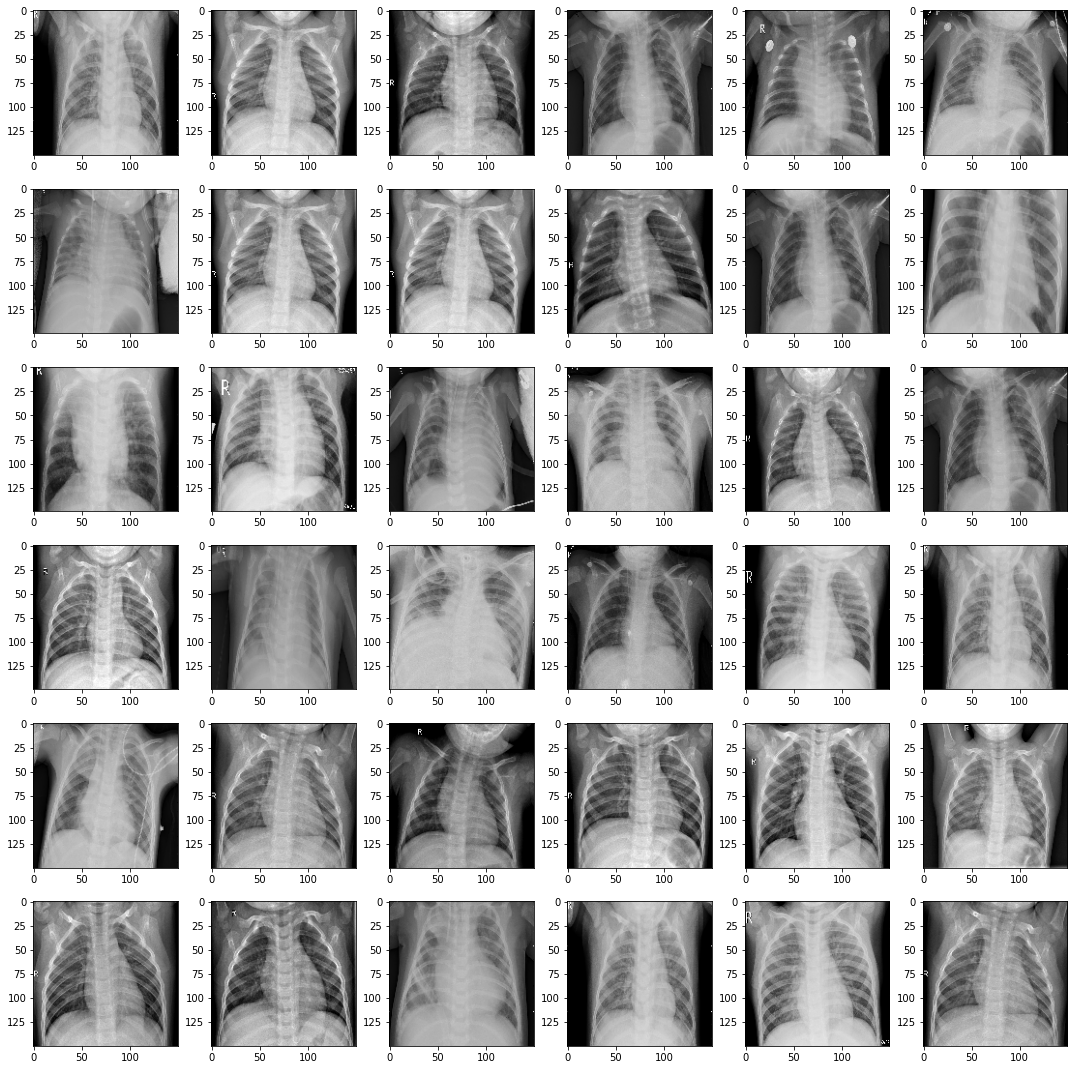

In [ ]:
visual_sample = [sample_training_images[int(random()*100)] for i in range(36)]

plotImages(visual_sample, 6, 6)

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. We also use a dropout layer, which is another tecnique to help us avoid overfitting. This tecnique consists of randomly turn off some neurons as the data go through the epocs, which force other neurons to do all the job. The model will output class probabilities for two classes — Normal and Pneumonia — using softmax in the last layer.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

## Compiling the model

We will use the adam optimizer, and keep up with training and validation accuracy on each epoch as we train our network.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

Let's take a look at our model architecture!

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Train the model

It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [ ]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 62s 1s/step - loss: 0.5134 - accuracy: 0.7587 - val_loss: 0.2353 - val_accuracy: 0.9085
Epoch 2/100
36/36 [==============================] - 50s 1s/step - loss: 0.2217 - accuracy: 0.9081 - val_loss: 0.1172 - val_accuracy: 0.9581
Epoch 3/100
36/36 [==============================] - 50s 1s/step - loss: 0.1343 - accuracy: 0.9477 - val_loss: 0.0948 - val_accuracy: 0.9615
Epoch 4/100
36/36 [==============================] - 50s 1s/step - loss: 0.1398 - accuracy: 0.9437 - val_loss: 0.1183 - val_accuracy: 0.9590
Epoch 5/100
36/36 [==============================] - 50s 1s/step - loss: 0.1135 - accuracy: 0.9573 - val_loss: 0.0763 - val_accuracy: 0.9752
Epoch 6/100
36/36 [==============================] - 50s 1s/step - loss: 0.1011 - accuracy: 0.9624 - val_loss: 0.0759 - val_accuracy: 0.9735
Epoch 7/100
36/36 [==============================] - 50s 1s/step - loss: 0.0912 - accuracy: 0.9642 - val_loss: 0.0677 - val_accuracy: 0.9752
Epoch 8/100
36/36 [======

# Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

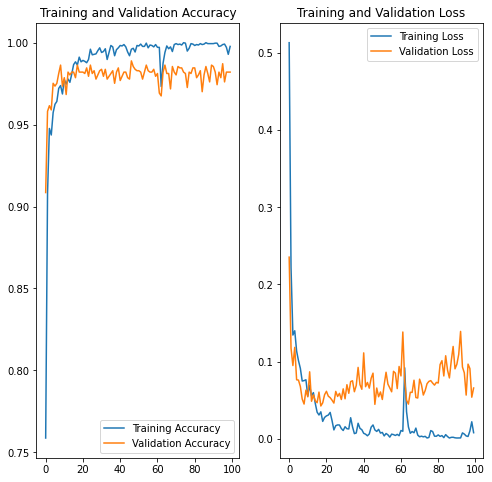

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, validation loss is increasing over epochs, which is an indication of overfitting.

In [ ]:
import math
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

12/12 [==============================] - 11s 806ms/step - loss: 1.8356 - accuracy: 0.8711
Accuracy on test dataset: 0.8710503578186035


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the train_dataset. When the model sees images it has never seen during training, (that is, from the test_dataset), we can expect performance to go down.

In [ ]:
import joblib

def save_model(model, model_filepath):
    """
    INPUT
        model - a trained model
        model_filepath - a file path to store the trained model
    """
    joblib.dump(model, model_filepath)

In [ ]:
save_model(model, 'chest-xray-classifier.pkl')